In [1]:
#Imports with Aliases and Config


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAvgPool2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Precision config
keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
# Training constants


TRAINING_CONFIG = {
    'epochs': 5,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'image_size': (160, 160)
}

# Load dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
print(f"Training data: {train_images.shape}, Test data: {test_images.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data: (50000, 32, 32, 3), Test data: (10000, 32, 32, 3)


In [3]:
  #Dataset Preparation


def prepare_dataset(images, labels, training=False):
    """Convert numpy arrays to optimized TF Dataset"""
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(lambda x, y: (
        tf.image.resize(x, TRAINING_CONFIG['image_size']) / 255.0,
        y
    ), num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(buffer_size=5000)

    return ds.batch(TRAINING_CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_ds = prepare_dataset(train_images, train_labels, training=True)
test_ds = prepare_dataset(test_images, test_labels)

In [4]:
  #Model Construction


def build_transfer_model():
    """Create MobileNetV2 based model with custom head"""
    # Base model (frozen)
    base = MobileNetV2(
        input_shape=(*TRAINING_CONFIG['image_size'], 3),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False

    # Custom classification head
    return Sequential([
        base,
        GlobalAvgPool2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax', dtype='float32')  # Ensure float32 for stability
    ])

model = build_transfer_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
  #Model Compilation


# Optimizer and compilation
optimizer = keras.optimizers.Adam(TRAINING_CONFIG['learning_rate'])
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
  #Training Execution


# Training with validation
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=TRAINING_CONFIG['epochs'],
    verbose=1
)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6770 - loss: 0.9485 - val_accuracy: 0.7960 - val_loss: 0.5741
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.7814 - loss: 0.6398 - val_accuracy: 0.8070 - val_loss: 0.5547
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.7948 - loss: 0.5933 - val_accuracy: 0.8241 - val_loss: 0.5155
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8032 - loss: 0.5658 - val_accuracy: 0.8188 - val_loss: 0.5275
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8128 - loss: 0.5431 - val_accuracy: 0.8234 - val_loss: 0.5153



Test Accuracy: 82.34%


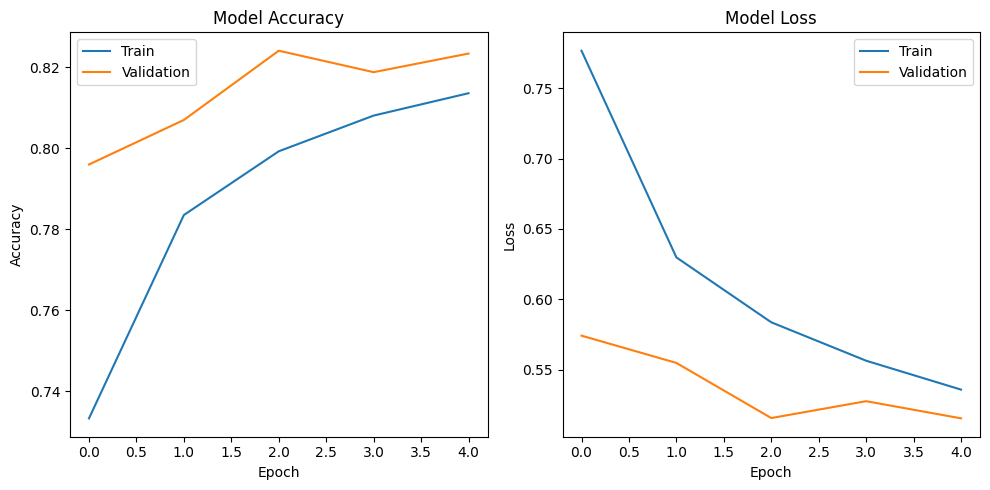

In [7]:
   #Evaluation and Visualization


import matplotlib.pyplot as plt

# Evaluate model
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
   #Sample Predictions (Optional)


# Class names for CIFAR-10
CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Get a test batch
sample_images, sample_labels = next(iter(test_ds))
predictions = model.predict(sample_images)

# Display first 5 predictions
print("\nSample Predictions:")
for i in range(5):
    pred_class = CLASS_NAMES[tf.argmax(predictions[i]).numpy()]
    true_class = CLASS_NAMES[sample_labels[i].numpy()[0]]
    confidence = tf.reduce_max(predictions[i]).numpy()
    print(f"Predicted: {pred_class:<10} | Actual: {true_class:<10} | Confidence: {confidence:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Sample Predictions:
Predicted: cat        | Actual: cat        | Confidence: 88.86%
Predicted: ship       | Actual: ship       | Confidence: 99.84%
Predicted: ship       | Actual: ship       | Confidence: 90.57%
Predicted: airplane   | Actual: airplane   | Confidence: 46.40%
Predicted: frog       | Actual: frog       | Confidence: 99.98%
